

# Train Practice

## *Data Science Unit 4 Sprint 2 Assignment 2*

Continue to use TensorFlow Keras & a sample of the [Quickdraw dataset](https://github.com/googlecreativelab/quickdraw-dataset) to build a sketch classification model. The dataset has been sampled to only 10 classes and 10000 observations per class. Please build a baseline classification model then run a few experiments with different optimizers and learning rates. 

*Don't forget to switch to GPU on Colab!*


------

# Objective 

We are going to run a few experiments today

- Train a model with and without normalized data and investigate the weight values and learning outcomes
- Train a model with varying values for batch_size, learning_rate, and optimizers

We are essentially running mannual gridsearches on our models. In module 3, we'll learn a few different ways to automate gridseach for deep learning. 

In [ ]:
# Import Statements
import os
import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, ReLU
from sklearn.model_selection import train_test_split

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.activations import relu
from tensorflow.keras.callbacks import TensorBoard

In [ ]:
%matplotlib inline
%load_ext tensorboard

### Load data

- Don't normalize your data just yet!

In [ ]:
# Fill out the doc string

def load_quickdraw10():
    """
    Loads the Quickdraw-10 dataset and splits it into training and testing sets.

    The Quickdraw-10 dataset consists of drawings of 10 different classes:
    - apple
    - anvil
    - airplane
    - banana
    - The Eiffel Tower
    - The Mona Lisa
    - The Great Wall of China
    - alarm clock
    - ant
    - asparagus

    Returns
    -------
      A tuple of four Numpy arrays: (X_train, X_test, y_train, y_test)

      X_train : A 2D Numpy array of shape (num_train_samples, num_features) representing the
             training data, where each row corresponds to a drawing and each column
             corresponds to a feature.

      X_test: A 2D Numpy array of shape (num_test_samples, num_features) representing the
            testing data, where each row corresponds to a drawing and each column
            corresponds to a feature.
            
      y_train: A 1D Numpy array of shape (num_train_samples,) representing the labels
             of the training data.
             
      y_test: A 1D Numpy array of shape (num_test_samples,) representing the labels
            of the testing data.
    """
    
    URL_ = "https://github.com/LambdaSchool/DS-Unit-4-Sprint-2-Neural-Networks/blob/main/quickdraw10.npz?raw=true"
    
    path_to_zip = tf.keras.utils.get_file('./quickdraw10.npz', origin=URL_, extract=False)

    data = np.load(path_to_zip)

    X = data['arr_0']
    Y = data['arr_1']
        
    return train_test_split(X, Y, shuffle=True)

In [ ]:
X_train, X_test, y_train, y_test = load_quickdraw10()

25421363/25421363 [==============================] - 1s 0us/step


In [ ]:
n_labels = len(np.unique(y_train))

In [ ]:
(np.unique(y_train))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

----
### Write a Model Function
- Write a function called `create_model` which returns a compiled TensorFlow Keras Sequential Model suitable for classifying the QuickDraw-10 dataset. 

Your function `create_model` should accept the following parameters

- Learning Rate `lr`
- Optimizer `opt`


Build a model with the following architecture and parameter values

- Use `1 hidden layer` 
- Use `sigmoid` activation function in hidden layer
- Use `250 nodes` in hidden layer 
- Use `10 nodes` in output layer
- Use `softmax` activation function in output layer
- Use `sparse_categorical_crossentropy` loss function
- Use `accuracy` as your metric 

We will use this function to build all the models that we'll need to run our experiments. 

In [ ]:
def create_model(lr=.01, opt="adam"):
    """
    
    Build and returns a compiled Keras model with the following architecture:
    
    - Two fully connected layers with 250 and 10 neurons, respectively.
    - Sigmoid activation function for the first layer and softmax for the second.  
    
    Parameters
    ----------
    lr: float
        Learning rate parameter used for Stochastic Gradient Descent 
        
    opt: string
        Name of optimizer to use
        Valid options are "adam" and "sgd"
        
    Returns
    -------
    model: keras object 
        A compiled keras model 
    """

    if opt == "adam":
        opt = Adam(learning_rate=lr)
    elif opt == "sgd":
        opt = SGD(learning_rate=lr)
    else:
        print ("{} is not a valid option. Defaulting to Adam optimizer".format(opt))
        opt = Adam(learning_rate=lr)

### BEGIN SOLUTION
    # build model here
    model = Sequential([
        # Hidden layer 1
        Dense(250, activation='sigmoid', input_dim=X_train.shape[1]),
        # Output layer
        Dense(10, activation='softmax')
        ])
    
    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model
### END SOLUTION 

In [ ]:
# check model architecture
model = create_model()
model.get_config()

{'name': 'sequential',
 'layers': [{'class_name': 'InputLayer',
   'config': {'batch_input_shape': (None, 784),
    'dtype': 'float32',
    'sparse': False,
    'ragged': False,
    'name': 'dense_input'}},
  {'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': 'float32',
    'batch_input_shape': (None, 784),
    'units': 250,
    'activation': 'sigmoid',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bias_initializer': {'class_name': 'Zeros', 'config': {}},
    'kernel_regularizer': None,
    'bias_regularizer': None,
    'activity_regularizer': None,
    'kernel_constraint': None,
    'bias_constraint': None}},
  {'class_name': 'Dense',
   'config': {'name': 'dense_1',
    'trainable': True,
    'dtype': 'float32',
    'units': 10,
    'activation': 'softmax',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'GlorotUniform',
     'config': {'seed': None}},
    'bi

In [ ]:
# check the number of layers
n_layers = len(model.get_config()["layers"])

# check the activation function of the last layer
output_act_funct =  model.get_config()["layers"][-1]["config"]["activation"]

# test for expected output
assert n_layers == 3, "You should have an input, one hidden, and an output layer"
assert output_act_funct == "softmax", "Output activation function should be softmax"

------

# Experiment #1: How does normalized input data affect our model's learning outcome?

In this experiment we are going to answer the above question by training a model on both a normalized data set and on a non-normalized data set. 

Then we will compare and analyze the trained weight values for the two cases.

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

### Fit Model on Non-Normalized data

In [ ]:
%%time
# Fit model on non-normalized data using keras API with tensorflow backend

# Define the directory where the logs for the TensorBoard callback will be stored
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # generates a unique log directory name for each experiment run
logdir = os.path.join("logs", f"No_Normalization-{now}")
# Create the TensorBoard callback object
tensorboard = TensorBoard(log_dir=logdir,  histogram_freq=1) # histograms will be computed at every epoch
# Create the architecture of the neural network model 
model = create_model(lr=.001, opt="adam") 
# Train the model using the non-normalized training data and validation data
model.fit(X_train, y_train,
          validation_data=(X_test, y_test),
          workers=-2, # keras will use all available CPUs except for one that will be for the operating system
          epochs=10, 
          batch_size=32, 
          verbose=1, 
          callbacks=[tensorboard]) # logs metrics like loss and accuracy during training

Epoch 1/10
2344/2344 [==============================] - 36s 14ms/step - loss: 0.9538 - accuracy: 0.7032 - val_loss: 0.8562 - val_accuracy: 0.7416
Epoch 2/10
2344/2344 [==============================] - 15s 7ms/step - loss: 0.8188 - accuracy: 0.7446 - val_loss: 0.7888 - val_accuracy: 0.7610
Epoch 3/10
2344/2344 [==============================] - 17s 7ms/step - loss: 0.7671 - accuracy: 0.7608 - val_loss: 0.7682 - val_accuracy: 0.7553
Epoch 4/10
2344/2344 [==============================] - 18s 8ms/step - loss: 0.7458 - accuracy: 0.7685 - val_loss: 0.7603 - val_accuracy: 0.7696
Epoch 5/10
2344/2344 [==============================] - 20s 8ms/step - loss: 0.7397 - accuracy: 0.7692 - val_loss: 0.7502 - val_accuracy: 0.7706
Epoch 6/10
2344/2344 [==============================] - 16s 7ms/step - loss: 0.7271 - accuracy: 0.7737 - val_loss: 0.7192 - val_accuracy: 0.7790
Epoch 7/10
2344/2344 [==============================] - 16s 7ms/step - loss: 0.7092 - accuracy: 0.7802 - val_loss: 0.7270 - val_a

---------

### Fit Model on Normalized data

In [ ]:
# Normalize your training and test sets 
# save normalized data to variables X_train_scaled and X_test_scaled

###BEGIN SOLUTION

# Calculate max_value for both the training and test sets separately
max_value_train = X_train.max()
max_value_test = X_test.max()

# Normalize data to values between 0 and 1
X_train_scaled = X_train / max_value_train
X_test_scaled = X_test / max_value_test

###END SOLUTION

In [ ]:
%%time
# Train model on normalized data

# Define the directory where the logs for the TensorBoard callback will be stored
now = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = os.path.join("logs", f"Normalization-{now}")
# Create the TensorBoard callback object
tensorboard = TensorBoard(log_dir=logdir,  histogram_freq=1)
# Create the architecture of the neural network model 
norm_model = create_model(lr=0.001, opt="adam")
# Train the model using the normalized training data and validation data
norm_model.fit(X_train_scaled, y_train, 
          validation_data=(X_test_scaled, y_test),
          workers=-2, 
          epochs=10, 
          batch_size=32, 
          verbose=1, 
          callbacks=[tensorboard])

Epoch 1/10
2344/2344 [==============================] - 16s 6ms/step - loss: 0.7745 - accuracy: 0.7704 - val_loss: 0.6252 - val_accuracy: 0.8158
Epoch 2/10
2344/2344 [==============================] - 17s 7ms/step - loss: 0.5550 - accuracy: 0.8351 - val_loss: 0.5327 - val_accuracy: 0.8443
Epoch 3/10
2344/2344 [==============================] - 17s 7ms/step - loss: 0.4707 - accuracy: 0.8602 - val_loss: 0.4828 - val_accuracy: 0.8554
Epoch 4/10
2344/2344 [==============================] - 17s 7ms/step - loss: 0.4151 - accuracy: 0.8771 - val_loss: 0.4593 - val_accuracy: 0.8636
Epoch 5/10
2344/2344 [==============================] - 17s 7ms/step - loss: 0.3718 - accuracy: 0.8891 - val_loss: 0.4470 - val_accuracy: 0.8699
Epoch 6/10
2344/2344 [==============================] - 15s 6ms/step - loss: 0.3377 - accuracy: 0.8999 - val_loss: 0.4350 - val_accuracy: 0.8724
Epoch 7/10
2344/2344 [==============================] - 16s 7ms/step - loss: 0.3075 - accuracy: 0.9086 - val_loss: 0.4276 - val_ac

### Each layer is labeled

Take note of the label for each layer in the network. It is these labels that will help you identify the corresponding bias and weight distributions on tensorboard. 

Assuming that you've run `create_model` 3 times: once for the model check, once to create `model`, and once to create `norm_model`:

The name of the layers for `model` should be 
- dense_2
- dense_3

The name of the layers for `norm_model` should be 
- dense_4
- dense_5


If you keep retraining one or both of these models, tensorflow will increment the integer used in the layer names.  But that doesn't really matter, just take notice of the layer names so you can find their corresponding bias and weight distribtuions in tensorboard.

**Pro Tip:** If you want to reset the integer incrementation that tensorflow uses, you'll need to restart your notebook's kernel. 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 250)               196250    
                                                                 
 dense_3 (Dense)             (None, 10)                2510      
                                                                 
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
norm_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 250)               196250    
                                                                 
 dense_5 (Dense)             (None, 10)                2510      
                                                                 
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________


### How to calculate the number of parameters in a neural network layer
Let's verify that the `dense_2` layer has 196250 parameters.<br>
The `dense_2` layer has $250$ neurons (also called units or nodes).<br>
Each neuron has a weights vector and a scalar bias.<br><br>
**Question:** How many weights does each neuron have?<br><br>
**Answer:** The number of a neuron's weights is equal to its number of inputs. <br>
The input to each neuron in this layer is a $28\times 28$ image, <br>composed of $784~(=~28^2)$ pixel values. <br>
Each neuron has $784$ inputs, and therefore $784$ weights.<br><br>
So the total number of parameters in the `dense_2` layer is<br><br>
$N_{dense\_2} = 250~~\text{neurons} \times (784~\text{weights per neuron} + 1 ~ \text{bias per neuron}) = 196250$

In [ ]:
# neurons * (weights per neuron + bias per neuron)
250 * (784 + 1)

196250

### Now your turn: can you verify that the number of parameters in the `dense_3` layer is $2510$?

### Your Explanation Here

To calculate the number of parameters in the `dense_3` layer, we add up the number of weights and biases. The input weights are determined by the output dimension of the previous layer, which is 250, and the number of neurons in the current layer, which is 10. The bias term is just 1 for each neuron. Therefore, the total number of parameters in the dense_3 layer is given by the formula (250 + 1) x 10, which equals 2510.

$N_{dense\_3} = (250\ neurons \ input \ from \ previous \ output \ layer + 1\ bias \ per \ neuron)\ x\ (10\ neurons) = 2510$


In [ ]:
# (output_dim of previous layer + 1 bias) * output_dim of layer 
(250 + 1) * 10

2510

### Tensorboard 

- Run the cell below to launch tensorboard 
- Click on the `SCALARS` tab to see plots that compare the loss and accuracy between the two models
- Cick on the `HISTOGRAMS` tab to see the distribution of the learned weights 

In [ ]:
%tensorboard --logdir logs

### Tensorboard 

Check out the loss and accuracy plots on the `SCALARS` tab. 

What you should see is that the accuracy is much higher for the model that was given normalized data; conversely, the loss is much lower for the model that was given normalized data. 

Recall that during training, the model is adjusting the value of the bias and weights in each layer. For simplicity of analysis, we only trained two layers: a hidden layer and the output layer. 

Now click on the `HISTOGRAM` tab. 

You should see both of your model's layer names. 

### Hidden Layer Distributions

Collapse the charts that correspond to the output layer so only the distributions for the weights and bias in the hidden layer are showing. (i.e. Only expand `dense_2` and `dense_4`). 

Also don't be confused by the word `kernel`, that's just the word that Tensorflow uses instead of weights. So, to be clear, **the kernel distributions are the weight values.** 

The `bias` distributions are the bias values. 

You should see 10 distributions stacked next to each other, **one distribution per epoch.**

The distribution at the far back corresponds to the weight values at epoch 1 (tensorflow starts the count at 0, like the index for a list). The distribution at the very front corresponds to the weight values at the 10th epoch (tensorflow indexing shows 9 instead of 10).

Notice how the shape of the distribution changes accross epochs? That's because their **values are being updated via Gradient Descent.**!

The distributions that you see are direclty responsible for the validation accuracy of our models. The reason why they look different between the two models is because one model was given normalized data and one wasn't. So you can conclude that the weight distributions in `dense_4` produce a higher validation accuracy than the weight distributions in `dense_2`. 

Now it's time to analyze those weight values more closely. 

----------
### Analyze Weights in Each Layer

In [ ]:
# get the final bias and weight matrices for model
layer = model.get_layer(name="dense_2")
bias, weights = layer.get_weights()

In [ ]:
# get the final  value bias and weight matrices for norm_model
layer = norm_model.get_layer(name="dense_4")
bias_norm, weights_norm = layer.get_weights()

In [ ]:
# this line of code should not throw an error if the number of weights is the same for the hidden layer of both models
# this line of code is known as a Unit Test 
assert weights.shape[0] == weights_norm.shape[0]

### Initial Weight Values

By default, Keras dense layers randomly initialize the weight values using [**GlorotUniform**](https://keras.io/api/layers/initializers/). 

The cell below is sampling values from the `GlorotUniform` distribution. Let's sample from the `GlorotUniform` distribution and plot it in order to get a sense of the initial distribution of our weights - before Gradient Descent starts updating their values at training time. 

In [ ]:
# let's take 250 random samples from GlorotUniform
# because they are random samples their exact values might have been a little different for model and norm_model - but we will assume that they were not statistically different 
# 250 because that's how many weights are in the hidden layer for both of our models
initializer = tf.keras.initializers.GlorotUniform(seed=42)
initial_weight_values = initializer(shape=(1, 250))

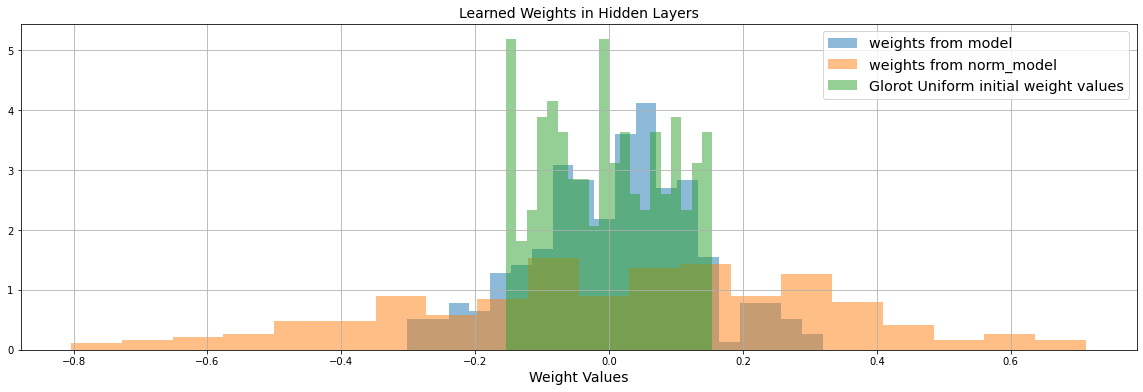

In [ ]:
plt.figure(figsize=(20,6))
plt.title("Learned Weights in Hidden Layers", fontsize=14)
plt.xlabel("Weight Values", fontsize=14)
plt.grid()

# By setting density=True, we are transforming our plots into probability distributions 
plt.hist(weights, bins=20, alpha=0.5, label="weights from model", density=True);
plt.hist(weights_norm, bins=20, alpha=0.5, label="weights from norm_model", density=True);
plt.hist(initial_weight_values, bins=20, alpha=0.5, label="Glorot Uniform initial weight values", density=True);
plt.legend(fontsize="x-large");

### Observations

Your plot should have 3 distributions

- weights from model trained on non-normalized data
- weights from model trained on normalized data
- initial weight values sampled from a Glorot Uniform distributions 

Use the plot to answer the following questions.

**Comparing the initial weights with weights_from_model, what was the effect of not using normalized data?**

YOUR ANSWER:

These two distributions have different ranges. In the distribution of weights from the non-normalized model (blue distribution) the input values to the model may have different magnitudes, leading to gradient updates that are too large or too small. The blue distribution has a wider range and longer tail to the right compared to the distribution of initial weights (green distribution). This suggests that some of the weights have become much larger in magnitude during training, which may cause instability or poor generalization performance.

Therefore, one potential effect of not using normalized data is that the weight values tend to becoming unbalanced and unstable during training.

**Comparing the initial weights with weights_from_norm_model, what was the effect of using normalized data?**

YOUR ANSWER:

From the plot, we can see that the Glorot Uniform initial weight values (green distribution) have a narrower range and smaller standard deviation compared to the orange distribution which represents the normalized data. The weights in the normalized model are spread out across a wider range, resembling a Gaussian distribution. 


----

# Additional Experiments

The previous experiment demonstrated the importance of normalizing our data in order to maximize model accuracy. In the next few experiments, we are going to explore the effects of varying Batch Size, Learning Rate, choice of Optimizer on model accuracy. 

Using our `create_model` model building function, conduct the following experiments. 

### Experiment with Batch Size
* Run 5 experiments with various batch sizes of your choice. 
* Visualize the results
* Write up an analysis of the experiments and select the "best" performing model among your experiments. Make sure to compare against your model's performance yesterday. 

In [ ]:
%%time
# Batch size = 8 (small)
# tf.keras.backend.clear_session()
# Instantiate a model and fit it with batch size of 8
norm_model = create_model()
bt_small_8 = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=8, 
                  verbose=1, 
                  callbacks=[tensorboard])


Epoch 1/10
9375/9375 [==============================] - 49s 5ms/step - loss: 0.7635 - accuracy: 0.7688 - val_loss: 0.7091 - val_accuracy: 0.7905
Epoch 2/10
9375/9375 [==============================] - 52s 6ms/step - loss: 0.6652 - accuracy: 0.8029 - val_loss: 0.6663 - val_accuracy: 0.8054
Epoch 3/10
9375/9375 [==============================] - 55s 6ms/step - loss: 0.6289 - accuracy: 0.8149 - val_loss: 0.6613 - val_accuracy: 0.8130
Epoch 4/10
9375/9375 [==============================] - 51s 5ms/step - loss: 0.6101 - accuracy: 0.8211 - val_loss: 0.6393 - val_accuracy: 0.8203
Epoch 5/10
9375/9375 [==============================] - 48s 5ms/step - loss: 0.5820 - accuracy: 0.8280 - val_loss: 0.6373 - val_accuracy: 0.8203
Epoch 6/10
9375/9375 [==============================] - 47s 5ms/step - loss: 0.5693 - accuracy: 0.8319 - val_loss: 0.6214 - val_accuracy: 0.8247
Epoch 7/10
9375/9375 [==============================] - 48s 5ms/step - loss: 0.5555 - accuracy: 0.8363 - val_loss: 0.6299 - val_ac

In [ ]:
norm_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 250)               196250    
                                                                 
 dense_7 (Dense)             (None, 10)                2510      
                                                                 
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir logs

In [ ]:
%%time
# Batch size = 15 (small)
tf.keras.backend.clear_session()
# Instantiate a model and fit it with batch size of 15
norm_model = create_model()
bt_small_15 = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=15, 
                  verbose=1, 
                  callbacks=[tensorboard])

Epoch 1/10
5000/5000 [==============================] - 34s 7ms/step - loss: 0.6978 - accuracy: 0.7859 - val_loss: 0.6311 - val_accuracy: 0.8091
Epoch 2/10
5000/5000 [==============================] - 29s 6ms/step - loss: 0.5958 - accuracy: 0.8199 - val_loss: 0.6129 - val_accuracy: 0.8149
Epoch 3/10
5000/5000 [==============================] - 29s 6ms/step - loss: 0.5615 - accuracy: 0.8307 - val_loss: 0.6505 - val_accuracy: 0.8103
Epoch 4/10
5000/5000 [==============================] - 30s 6ms/step - loss: 0.5480 - accuracy: 0.8355 - val_loss: 0.6033 - val_accuracy: 0.8238
Epoch 5/10
5000/5000 [==============================] - 30s 6ms/step - loss: 0.5251 - accuracy: 0.8407 - val_loss: 0.5928 - val_accuracy: 0.8310
Epoch 6/10
5000/5000 [==============================] - 29s 6ms/step - loss: 0.5100 - accuracy: 0.8467 - val_loss: 0.6192 - val_accuracy: 0.8212
Epoch 7/10
5000/5000 [==============================] - 31s 6ms/step - loss: 0.4953 - accuracy: 0.8497 - val_loss: 0.5840 - val_ac

In [ ]:
norm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 250)               196250    
                                                                 
 dense_1 (Dense)             (None, 10)                2510      
                                                                 
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir logs

In [ ]:
%%time
# Batch size = 30 (close to default)
# Instantiate a model and fit it with batch size of 30
norm_model = create_model()
bt_30 = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=30, 
                  verbose=1, 
                  callbacks=[tensorboard])

Epoch 1/10
2500/2500 [==============================] - 18s 7ms/step - loss: 0.6607 - accuracy: 0.7969 - val_loss: 0.5713 - val_accuracy: 0.8311
Epoch 2/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.5521 - accuracy: 0.8338 - val_loss: 0.5801 - val_accuracy: 0.8232
Epoch 3/10
2500/2500 [==============================] - 16s 6ms/step - loss: 0.5197 - accuracy: 0.8431 - val_loss: 0.5622 - val_accuracy: 0.8356
Epoch 4/10
2500/2500 [==============================] - 20s 8ms/step - loss: 0.4874 - accuracy: 0.8524 - val_loss: 0.5542 - val_accuracy: 0.8384
Epoch 5/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.4666 - accuracy: 0.8590 - val_loss: 0.5425 - val_accuracy: 0.8399
Epoch 6/10
2500/2500 [==============================] - 15s 6ms/step - loss: 0.4494 - accuracy: 0.8639 - val_loss: 0.5458 - val_accuracy: 0.8438
Epoch 7/10
2500/2500 [==============================] - 17s 7ms/step - loss: 0.4288 - accuracy: 0.8690 - val_loss: 0.5549 - val_ac

In [ ]:
norm_model.summary()

In [ ]:
%tensorboard --logdir logs

In [ ]:
%%time
# Batch size = 120 (large)
# Instantiate a model and fit it with batch size of 120
norm_model = create_model()
bt_large_120 = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=120, 
                  verbose=1, 
                  callbacks=[tensorboard])

Epoch 1/10
625/625 [==============================] - 6s 8ms/step - loss: 0.6679 - accuracy: 0.7966 - val_loss: 0.5442 - val_accuracy: 0.8358
Epoch 2/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4799 - accuracy: 0.8554 - val_loss: 0.4866 - val_accuracy: 0.8544
Epoch 3/10
625/625 [==============================] - 5s 8ms/step - loss: 0.4172 - accuracy: 0.8736 - val_loss: 0.4943 - val_accuracy: 0.8546
Epoch 4/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3791 - accuracy: 0.8847 - val_loss: 0.4959 - val_accuracy: 0.8575
Epoch 5/10
625/625 [==============================] - 5s 9ms/step - loss: 0.3442 - accuracy: 0.8933 - val_loss: 0.5002 - val_accuracy: 0.8566
Epoch 6/10
625/625 [==============================] - 5s 8ms/step - loss: 0.3149 - accuracy: 0.9031 - val_loss: 0.5004 - val_accuracy: 0.8583
Epoch 7/10
625/625 [==============================] - 6s 9ms/step - loss: 0.2867 - accuracy: 0.9107 - val_loss: 0.5303 - val_accuracy: 0.8538
Epoch 

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 250)               196250    
                                                                 
 dense_3 (Dense)             (None, 10)                2510      
                                                                 
Total params: 198,760
Trainable params: 198,760
Non-trainable params: 0
_________________________________________________________________


In [ ]:
%tensorboard --logdir logs

In [ ]:
%%time
# Batch size = 300 (large)
# Instantiate a model and fit it with batch size of 300
norm_model = create_model()
bt_large_300 = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

Epoch 1/10
250/250 [==============================] - 4s 14ms/step - loss: 0.7384 - accuracy: 0.7777 - val_loss: 0.5609 - val_accuracy: 0.8324
Epoch 2/10
250/250 [==============================] - 4s 15ms/step - loss: 0.4967 - accuracy: 0.8510 - val_loss: 0.4937 - val_accuracy: 0.8540
Epoch 3/10
250/250 [==============================] - 3s 13ms/step - loss: 0.4194 - accuracy: 0.8737 - val_loss: 0.4620 - val_accuracy: 0.8626
Epoch 4/10
250/250 [==============================] - 3s 14ms/step - loss: 0.3662 - accuracy: 0.8888 - val_loss: 0.4542 - val_accuracy: 0.8662
Epoch 5/10
250/250 [==============================] - 4s 16ms/step - loss: 0.3213 - accuracy: 0.9026 - val_loss: 0.4596 - val_accuracy: 0.8668
Epoch 6/10
250/250 [==============================] - 3s 14ms/step - loss: 0.2827 - accuracy: 0.9150 - val_loss: 0.4819 - val_accuracy: 0.8614
Epoch 7/10
250/250 [==============================] - 3s 14ms/step - loss: 0.2512 - accuracy: 0.9234 - val_loss: 0.4817 - val_accuracy: 0.8652

In [ ]:
norm_model.summary()

In [ ]:
%tensorboard --logdir logs

In [ ]:
bt_30.history

In [ ]:
dd = pd.DataFrame.from_dict(bt_30.history)
dd

,loss,accuracy,val_loss,val_accuracy
0,0.660650,0.796853,0.571257,0.83112
1,0.552121,0.833840,0.580136,0.82320
2,0.519687,0.843147,0.562193,0.83556
3,0.487423,0.852387,0.554209,0.83844
4,0.466553,0.859040,0.542484,0.83988
5,0.449412,0.863880,0.545779,0.84376
6,0.428799,0.869027,0.554881,0.84484
7,0.412925,0.873160,0.547159,0.84636
8,0.401554,0.876627,0.546436,0.84644
9,0.385834,0.881667,0.562050,0.84656


In [ ]:
experiment_dfs = []

for experiment, label in zip([bt_30, bt_small_8, bt_small_15, bt_large_120, bt_large_300], ["30_", "8_", "15_", "120_", "300_"]):

    df = pd.DataFrame.from_dict(experiment.history)
    df['epoch'] = df.index.values
    df['Batch Size'] = label

    # append to list of experiment data frames
    experiment_dfs.append(df)

df = pd.concat(experiment_dfs,ignore_index=True)
df['Batch Size'] = df['Batch Size'].astype('str')
df

,loss,accuracy,val_loss,val_accuracy,epoch,Batch Size
0,0.660650,0.796853,0.571257,0.83112,0,30_
1,0.552121,0.833840,0.580136,0.82320,1,30_
2,0.519687,0.843147,0.562193,0.83556,2,30_
3,0.487423,0.852387,0.554209,0.83844,3,30_
4,0.466553,0.859040,0.542484,0.83988,4,30_
5,0.449412,0.863880,0.545779,0.84376,5,30_
6,0.428799,0.869027,0.554881,0.84484,6,30_
7,0.412925,0.873160,0.547159,0.84636,7,30_
8,0.401554,0.876627,0.546436,0.84644,8,30_
9,0.385834,0.881667,0.562050,0.84656,9,30_


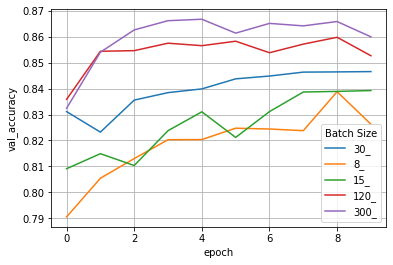

In [ ]:
import seaborn as sns 
sns.lineplot(x='epoch', y='val_accuracy', hue='Batch Size', data=df);
plt.grid()

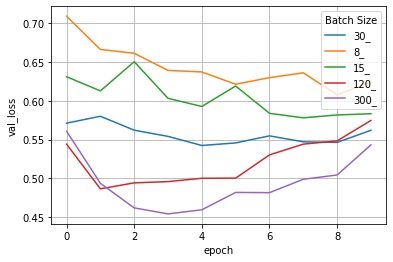

In [ ]:
sns.lineplot(x='epoch', y='val_loss', hue='Batch Size', data=df);
plt.grid()

YOUR ANSWER

- EXPERIMENT ANALYSIS:

Modifying the batch size has an effect on the model's performance. Based on the visualizations presented, it appears that the validation loss decreases as the number of epochs increases for all batch sizes. However, it is apparent that the lowest validation loss values were attained using larger batch sizes. This suggests that using larger batch sizes may lead to better performance on the Quickdraw-10 dataset. Also, larger batch sizes demonstrated shorter training times in comparison to smaller batch sizes.

In terms of validation accuracy,  there seems to be a trade-off between using larger batch sizes and achieving higher accuracy. While larger batch sizes do tend to achieve a higher validation accuracy overall, the accuracy appears to plateau after a certain number of epochs and slightly decreases for the last few epochs.


- SELECT THE BEST PERFORMING MODEL:

Based on the validation loss and accuracy curves, it appears that the 300 batch size may be the best performing model. This batch size achieves the lowest validation loss and highest validation accuracy overall.

### Experiment with Learning Rate
* Run 5 experiments with various learning rate magnitudes: 1, 0.1, 0.01, 0.001, 0.0001.
* Use the "best" batch size from the previous experiment
* Visualize the results using `tensorboard`
* Write up an analysis of the experiments and select the "best" performing model among your experiments. Make sure to compare against the previous experiments and your model's performance yesterday. 

In [ ]:
norm_model = create_model(lr=1.0)
lr_1 = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

Epoch 1/10
250/250 [==============================] - 4s 15ms/step - loss: 7.5837 - accuracy: 0.4312 - val_loss: 2.6629 - val_accuracy: 0.3648
Epoch 2/10
250/250 [==============================] - 4s 16ms/step - loss: 2.1992 - accuracy: 0.4994 - val_loss: 1.7163 - val_accuracy: 0.4712
Epoch 3/10
250/250 [==============================] - 3s 13ms/step - loss: 2.2176 - accuracy: 0.5265 - val_loss: 1.7766 - val_accuracy: 0.5188
Epoch 4/10
250/250 [==============================] - 3s 13ms/step - loss: 2.2558 - accuracy: 0.5229 - val_loss: 2.3335 - val_accuracy: 0.5561
Epoch 5/10
250/250 [==============================] - 5s 21ms/step - loss: 2.3419 - accuracy: 0.5341 - val_loss: 1.3232 - val_accuracy: 0.6132
Epoch 6/10
250/250 [==============================] - 4s 17ms/step - loss: 2.1067 - accuracy: 0.5502 - val_loss: 1.7747 - val_accuracy: 0.5572
Epoch 7/10
250/250 [==============================] - 4s 17ms/step - loss: 1.9951 - accuracy: 0.5586 - val_loss: 1.6178 - val_accuracy: 0.6216

In [ ]:
%tensorboard --logdir logs

In [ ]:
norm_model = create_model(lr=0.1)
lr_0_1_ = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

In [ ]:
%tensorboard --logdir logs

In [ ]:
norm_model = create_model(lr=0.01)
lr_0_01_ = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

In [ ]:
%tensorboard --logdir logs

In [ ]:
norm_model = create_model(lr=0.001)
lr_0_001_ = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

In [ ]:
%tensorboard --logdir logs

In [ ]:
norm_model = create_model(lr=0.0001)
lr_0_0001_ = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

In [ ]:
%tensorboard --logdir logs

In [ ]:
experiments = []

for experiment, label in zip([lr_1, lr_0_1_, lr_0_01_, lr_0_01_, lr_0_0001_], ["1.0_", ".01_", ".01_", ".001_", ".0001_"]):

    df = pd.DataFrame.from_dict(experiment.history)
    df['epoch'] = df.index.values
    df['Learning Rate'] = label

    experiments.append(df)

df = pd.concat(experiments,ignore_index=True)
df['Learning Rate'] = df['Learning Rate'].astype('str')
df

In [ ]:
sns.lineplot(x='epoch', y='val_accuracy', hue='Learning Rate', data=df);
plt.grid()

In [ ]:
sns.lineplot(x='epoch', y='val_loss', hue='Learning Rate', data=df);
plt.grid()

YOUR ANSWER:

- EXPERIMENT ANALYSIS AND BEST PERFORMING MODEL:

Based on the learning rate performance visualization, it appears that the best performing model is likely the one with a learning rate of 0.001, as it achieves the lowest validation loss and highest validation accuracy overall.

The learning rate of 1.0 appears to be too high for this particular model. The validation loss starts very high and ther validation accuracy starts very low. Neither of them show signs of improvement over the course of training. This model is not generalizing well to the validation set and is likely overfitting the training data.

The validation accuracy for the model with learning rate of 0.1 appears to start decreasing after around 5-6 epochs, indicating that the model is overfitting to the training data. This behavior is consistent with the trend observed in the validation loss plot, where the validation loss starts increasing after around the same number of epochs.

The model with a lower learning rate of 0.0001 appears to have slower convergence, as it achieves lower validation accuracy and higher validation loss in the early epochs.



### Experiment with different Optimizers
* Run a experiments with SGD optimizer available in TensorFlow. See documentation for [`tf.keras.optimizers`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers)
* Visualize the results using `tensorboard`
* Write up an analysis of the experiments and select the "best" performing model among your experiments. Make sure to compare against the previous experiments and your model's performance yesterday.
* Repeat the experiment, this time combining Learning Rate and different optimizers in the same run. Does the best performing model change? 

In [ ]:
norm_model = create_model(lr=0.001, opt='sgd')
sgd_opt = norm_model.fit(X_train_scaled, y_train, 
                  validation_data=(X_test_scaled, y_test),
                  workers=-2, 
                  epochs=10, 
                  batch_size=300, 
                  verbose=1, 
                  callbacks=[tensorboard])

In [ ]:
%tensorboard --logdir logs

YOUR ANSWER:

It is evident that the model with the Adam optimizer outperformed the one with the Stochastic Gradient Descent (SGD) optimizer based on the loss and accuracy metrics.

------

## Stretch Goals: 

- On the learning rate experiments, implement [EarlyStopping](https://keras.io/api/callbacks/early_stopping/)
- Review the math of Gradient Descent. 

In [ ]:
def scheduler(epoch):
    lr = 1e-3 * 10**(epoch/5)
    return lr

# Here is the callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
epochs = 10
batch_size = 300
model_for_lr_schedule = create_model()
history_for_lr_schedule = model_for_lr_schedule.fit(X_train, y_train, batch_size=batch_size,callbacks=[lr_schedule] , epochs=epochs)

Epoch 1/10
250/250 [==============================] - 4s 13ms/step - loss: 1.0154 - accuracy: 0.6862 - lr: 0.0010
Epoch 2/10
250/250 [==============================] - 3s 11ms/step - loss: 0.8083 - accuracy: 0.7563 - lr: 0.0016
Epoch 3/10
250/250 [==============================] - 3s 12ms/step - loss: 0.8017 - accuracy: 0.7559 - lr: 0.0025
Epoch 4/10
250/250 [==============================] - 3s 13ms/step - loss: 0.8360 - accuracy: 0.7412 - lr: 0.0040
Epoch 5/10
250/250 [==============================] - 5s 18ms/step - loss: 0.8894 - accuracy: 0.7193 - lr: 0.0063
Epoch 6/10
250/250 [==============================] - 3s 11ms/step - loss: 0.9704 - accuracy: 0.6865 - lr: 0.0100
Epoch 7/10
250/250 [==============================] - 3s 11ms/step - loss: 1.0387 - accuracy: 0.6594 - lr: 0.0158
Epoch 8/10
250/250 [==============================] - 3s 11ms/step - loss: 1.1447 - accuracy: 0.6184 - lr: 0.0251
Epoch 9/10
250/250 [==============================] - 3s 14ms/step - loss: 1.2825 - accu

YOUR ANSWER:

We can observe that after epoch 2 the validation accuracy starts dropping and after epoch 5, the validation loss begins to rise as the learning rate increases, indicating that the model is no longer generalizing well and is overfitting the training data. This pattern shows that when we increase the learning rate too much, the optimizer may go past the best values for the model's weights, leading to poorer performance.